In [1]:
import copick
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers, models
from keras.api.losses import BinaryCrossentropy
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from numba import njit, prange
import time
from sklearn.model_selection import train_test_split
from keras.api.utils import Sequence
from keras.api.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import datetime


In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../copick_config.json' if split == 'train' else '../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root


In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals


In [4]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks


In [5]:
@njit(parallel=True)
def add_gaussian_to_heatmap_max(heatmap, z, y, x, kernel, half_size, depth, height, width):
    """
    Adds a Gaussian kernel to the heatmap at the specified (z, y, x) location using maximum.
    """
    for i in prange(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            for k in range(kernel.shape[2]):
                zi = z + i - half_size
                yi = y + j - half_size
                xi = x + k - half_size
                if 0 <= zi < depth and 0 <= yi < height and 0 <= xi < width:
                    if kernel[i, j, k] > heatmap[zi, yi, xi]:
                        heatmap[zi, yi, xi] = kernel[i, j, k]


In [6]:
def generate_heatmaps_optimized_max(df, tomogram_shape, particle_types):
    """
    Optimized function to generate 3D heatmaps for particle locations with maximum Gaussian spread.
    """
    depth, height, width = tomogram_shape
    num_classes = len(particle_types)
    heatmaps = np.zeros((depth, height, width, num_classes), dtype=np.float32)

    # Map particle types to channels
    particle_to_channel = {particle: i for i, particle in enumerate(particle_types)}

    # Group by 'particle' and 'radius'
    grouped = df.groupby(['particle', 'radius'])

    # Precompute Gaussian kernels for each group with adjusted sigma
    kernels = {}
    for (particle, radius), group in grouped:
        # Adjust sigma to ensure rapid decay within radius
        sigma = radius  # Consider setting to radius / 3 for faster decay
        if sigma == 0:
            # Handle cases where radius is zero to avoid division by zero
            kernel = np.zeros((1, 1, 1), dtype=np.float32)
            kernel[0, 0, 0] = 1.0
            kernels[(particle, radius)] = (kernel, 0)
            continue

        # Define the size of the kernel; typically 6*sigma to capture the Gaussian effectively
        kernel_size = int(6 * sigma) + 1  # Ensure kernel size is odd
        half_size = kernel_size // 2
        x = np.arange(-half_size, half_size + 1)
        y = np.arange(-half_size, half_size + 1)
        z_axis = np.arange(-half_size, half_size + 1)
        zz, yy_grid, xx = np.meshgrid(z_axis, y, x, indexing='ij')
        kernel = np.exp(-(xx ** 2 + yy_grid ** 2 + zz ** 2) / (2 * sigma ** 2))
        kernel /= kernel.max()  # Normalize the kernel peak to 1
        kernels[(particle, radius)] = (kernel.astype(np.float32), half_size)

    # Iterate over groups and add Gaussian kernels to the heatmaps
    for (particle, radius), (kernel, half_size) in tqdm(kernels.items(), desc="Generating Heatmaps"):
        channel = particle_to_channel[particle]
        # Extract all particles in the current group
        mask = (df['particle'] == particle) & (df['radius'] == radius)
        particles = df[mask][['z', 'y', 'x']].to_numpy().astype(np.int32)  # Order: z, y, x

        # Add Gaussian kernels to the heatmap using maximum
        for z, y, x in particles:
            add_gaussian_to_heatmap_max(
                heatmaps[..., channel],
                z, y, x,
                kernel, half_size,
                depth, height, width
            )

    return heatmaps


In [7]:
def overlay_heatmaps_on_tomogram(tomogram_slice, heatmaps_slice, particle_types, threshold=0.3):
    """
    Overlays colored heatmaps onto a tomogram slice.

    Args:
        tomogram_slice (np.ndarray): 2D tomogram slice.
        heatmaps_slice (np.ndarray): 3D heatmap slice (height, width, num_classes).
        particle_types (list): List of particle types.
        threshold (float): Intensity threshold for heatmap visibility.

    Returns:
        None: Displays the overlay plot.
    """
    # Normalize tomogram slice to [0, 1]
    tomogram_normalized = (tomogram_slice - tomogram_slice.min()) / (tomogram_slice.max() - tomogram_slice.min())
    tomogram_rgb = np.stack([tomogram_normalized] * 3, axis=-1)  # Convert grayscale to RGB

    # Generate distinct colors for each particle type
    cmap = plt.cm.get_cmap('tab10', len(particle_types))
    particle_colors = [cmap(i)[:3] for i in range(len(particle_types))]

    # Initialize an RGB array for the heatmap overlay
    overlay = np.zeros_like(tomogram_rgb, dtype=np.float32)

    for i, particle_color in enumerate(particle_colors):
        heatmap = heatmaps_slice[..., i]
        mask = heatmap > threshold
        for c in range(3):
            overlay[..., c] += particle_color[c] * mask.astype(np.float32)

    # Combine the tomogram with the overlay
    combined = tomogram_rgb + overlay
    combined = np.clip(combined, 0, 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(combined, interpolation='nearest')
    plt.axis('off')
    plt.title('Tomogram Slice with Heatmap Overlay')
    plt.show()


In [8]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')

In [9]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_99_9', 'TS_6_6', 'TS_86_3', 'TS_73_6']


In [10]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 7
Number of test tomograms: 3


In [11]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


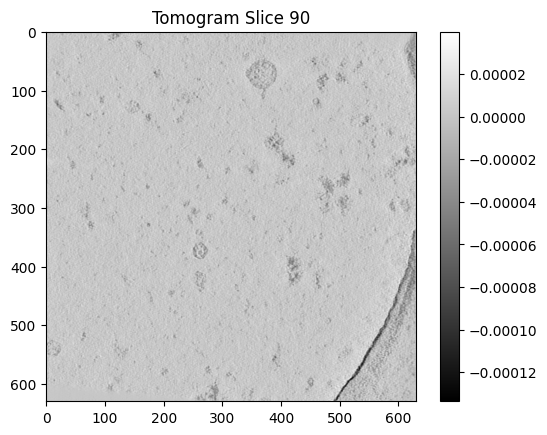

In [12]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [13]:
# Create DataFrame with particle locations
rows = []
for run in training_run_names:
    try:
        label_data = get_label_locations(run, copick_root_train)
        for particle, locations in label_data.items():
            matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if
                                  obj.name == particle]
            if not matching_particles:
                print(f"No matching particle found for {particle} in run {run}")
                continue
            radius = matching_particles[0] / 10
            for location in locations:
                rows.append({
                    'run': run,
                    'particle': particle,
                    'x': location[0],
                    'y': location[1],
                    'z': location[2],
                    'radius': radius
                })
    except Exception as e:
        print(f"Error processing labels for run {run}: {e}")

particle_locations_df = pd.DataFrame(rows)
print(particle_locations_df.sample(5))
print(f"Total labeled particles: {len(particle_locations_df)}")


          run            particle         x         y         z  radius
1155  TS_99_9  beta-galactosidase   43.0436  576.2282   97.2349     9.0
397    TS_6_4        apo-ferritin  498.4373  565.5125   99.3835     6.0
214   TS_69_2        apo-ferritin   77.0625  111.1161  108.8795     6.0
1144  TS_99_9  beta-galactosidase  569.2178   36.3770   82.2506     9.0
1068  TS_99_9            ribosome  211.6336  518.9631  102.7456    15.0
Total labeled particles: 1269


In [14]:
# Define particle types and tomogram shape
particle_types = sorted(particle_locations_df['particle'].unique())
if tomograms_train:
    tomogram_shape = tomograms_train[0]['tomogram'].shape
    print(f"Tomogram shape: {tomogram_shape}")
else:
    raise ValueError("No training tomograms available to determine shape.")


Tomogram shape: (184, 630, 630)


In [15]:
# Initialize the data generator
batch_size = 2  # Adjust based on your hardware capabilities

In [16]:
# Split tomograms into training and validation sets
tomograms_train_split, tomograms_val_split = train_test_split(
    tomograms_train,
    test_size=0.2,
    random_state=42
)

train_tom_mvp = tomograms_train[0]['tomogram'][90:110,300:330,300:330]
val_tom_mvp = tomograms_train[0]['tomogram'][50:70,200:230,200:230]


## I want to get the heatmaps in this area for val and train too

In [20]:
# Assuming 'particle_locations_df' is your DataFrame
particle_types = particle_locations_df['particle'].unique()
tomogram_shape = (180, 630,630)  # Example tomogram shape

start_time = time.time()
heatmaps = generate_heatmaps_optimized_max(particle_locations_df, tomogram_shape, particle_types)

Generating Heatmaps: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


In [27]:
train_heatmap_mvp = heatmaps[90:110,300:330,300:330,:]
val_heatmap_mvp = heatmaps[50:70,200:230,200:230,:]

(20, 30, 30, 6)

In [28]:
def build_3d_cnn(input_shape, num_classes):
    """
    Builds a simple 3D CNN model that maintains the spatial dimensions of the input.

    Args:
        input_shape (tuple): Shape of the input data (depth, height, width, channels).
        num_classes (int): Number of output classes.

    Returns:
        keras.Model: The constructed 3D CNN model.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)  # Downsample by 2
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)  # Downsample by 2
    # Decoder
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    
    # Output
    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

# Build the 3D CNN model with matching output dimensions
input_shape = (train_tom_mvp.shape[0], train_tom_mvp.shape[1], train_tom_mvp.shape[2], 1)  # (depth, height, width, channels)
num_classes = len(particle_types)
model = build_3d_cnn(input_shape=input_shape, num_classes=num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 30, 30, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 20, 30, 30, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 15, 15, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 10, 15, 15, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 8, 8, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 5, 8, 8, 32)    │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 5, 8, 8, 6)     │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,182 (164.77 KB)

 Trainable params: 42,182 (164.77 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
loss = BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [24]:
# Define callbacks
log_dir = f"./logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [42]:
len(tomograms_train_split)

2